This notebook aims on making a letter detection model to detect if the king is on the "E" or "D" row - to understand the color of the player.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

Transformation for the images from a dataset

In [2]:
from torchvision.io import read_image

def load_img(fname):
    img = read_image(fname)
    x = img / 255.
    
    transform = transforms.Compose([
        transforms.Resize((20, 20)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    return transform(x)

In [3]:
import pandas as pd

train_features = pd.read_csv(f"../data/corners/image_labels.csv")

train_features.columns

Index(['image_path', 'label'], dtype='object')

Replacing alphabetical features with numerical ones (classifying)

In [4]:
img_path = "../data/corners"

# Load and transform images 
images = torch.stack([load_img(f"{img_path}/{item['image_path']}") for _, item in  train_features.iterrows()])

# Select label(s) from train_features
labels = train_features['label']
# Leave values that only 1 or 0 and convert to float just for simplicity
labels.replace('-', 0, inplace=True)
labels.replace('D', 1, inplace=True)
labels.replace('E', 2, inplace=True)
labels = torch.from_numpy(labels.to_numpy()).float()

C:\Users\Zaurall\AppData\Local\Temp\ipykernel_11464\3175941237.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels.replace('E', 2, inplace=True)


In [5]:
images.shape, labels.shape

(torch.Size([64, 3, 20, 20]), torch.Size([64]))

Splitting data frame to test the model

In [6]:
processed_dataset = TensorDataset(images, labels)

# Set proportion and split dataset into train and validation parts
proportion = 0.8

train_dataset, val_dataset = torch.utils.data.random_split(
    processed_dataset,
   [(int(len(images) * proportion)), len(images) - int(len(images) * proportion)],
)

In [7]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

Testing data loaders

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.2009807].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7645023..2.2710087].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4275379..2.2710087].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5350274..1.9920374].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.29740003..1.9920374].


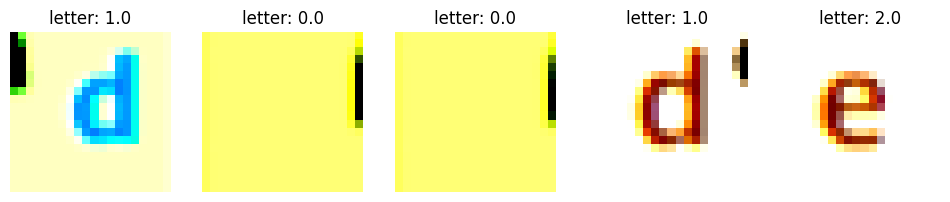

In [8]:
import matplotlib.pyplot as plt


for images, labels in train_loader:
    fig, axes = plt.subplots(1, 5, figsize=(12, 4))
    for i in range(5):
        ax = axes[i]

        img = images[i]
        img = img.permute(1, 2, 0)

        ax.imshow(img)
        ax.set_title(f'letter: {labels[i].item()}')
        ax.axis('off')
    plt.show()
    break

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training the model

In [11]:
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        labels = labels.long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            labels = labels.long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%')

# Save the model
torch.save(model.state_dict(), '../models/letter_detection_model.pt')

Epoch 1/40, Loss: 1.093811571598053
Validation Loss: 1.035690426826477, Accuracy: 69.23076923076923%
Epoch 2/40, Loss: 1.075357973575592
Validation Loss: 0.8994680643081665, Accuracy: 69.23076923076923%
Epoch 3/40, Loss: 1.0538113713264465
Validation Loss: 0.879233717918396, Accuracy: 69.23076923076923%
Epoch 4/40, Loss: 1.0332316756248474
Validation Loss: 0.9043020606040955, Accuracy: 69.23076923076923%
Epoch 5/40, Loss: 0.9891873896121979
Validation Loss: 0.7844113707542419, Accuracy: 84.61538461538461%
Epoch 6/40, Loss: 0.9367756545543671
Validation Loss: 0.7974169850349426, Accuracy: 84.61538461538461%
Epoch 7/40, Loss: 0.866126149892807
Validation Loss: 0.6353638768196106, Accuracy: 84.61538461538461%
Epoch 8/40, Loss: 0.7436406016349792
Validation Loss: 0.5677130222320557, Accuracy: 92.3076923076923%
Epoch 9/40, Loss: 0.6457114815711975
Validation Loss: 0.3834956884384155, Accuracy: 92.3076923076923%
Epoch 10/40, Loss: 0.6094653606414795
Validation Loss: 0.4472598731517792, Accur

The model is accurate. The next cell is the example of usage.

In [13]:
model = SimpleCNN()
model.load_state_dict(torch.load('../models/letter_detection_model.pt'))
model.eval()

with torch.no_grad():
    for inputs, labels in train_loader: #Change loader to some different input
        labels = labels.long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        print(f'Predicted: {predicted}, Actual: {labels}')

Predicted: tensor([0, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 2, 2, 2, 2, 2]), Actual: tensor([0, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 2, 2, 2, 2, 2])
Predicted: tensor([0, 1, 1, 1, 2, 2, 0, 2, 0, 2, 1, 0, 2, 1, 1, 0, 0, 0, 1]), Actual: tensor([0, 1, 1, 1, 2, 2, 0, 2, 0, 2, 1, 0, 2, 1, 1, 0, 0, 0, 1])


C:\Users\Zaurall\AppData\Local\Temp\ipykernel_11464\596966827.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../models/letter_detectio